In [3]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.mmd_loss import MMD
import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm
from rich.progress import track
from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak

from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor
from memflow.unfolding_flow.utils import Compute_ParticlesTensor

pi = torch.pi

torch.set_num_threads(20)

In [4]:
batchSize = 1024
path_data = '/work/dvalsecc/MEM/datasets/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_train.parquet'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

model_dir = "/work/dvalsecc/MEM/models_archive/flow_pretraining_huber_mmd_labframe_gluon/distrubuted_lxplus/preTraining_spanet_labframe_v2-gluon-dist-redo5_hiddenFeatures:64_dimFeedForward:512_nheadEnc:8_LayersEnc:4_nheadDec:4_LayersDec:4"
#model_dir = "/work/dvalsecc/MEM/models_archive/flow_pretraining_huber_mmd_labframe/preTraining_spanet_labframe_v2b-eregr_hiddenFeatures:64_dimFeedForward:512_nheadEnc:8_LayersEnc:4_nheadDec:4_LayersDec:4/"

#model_dir= '/work/dvalsecc/MEM/models_archive/flow_pretraining_spanet/preTraining_spanet_v2_noProv:True_cartesian:False_HuberLoss:True_latent_space:True_hiddenFeatures:64_dimFeedForward:1024_nheadEnc:4_LayersEnc:6_nheadDec:4_LayersDec:4/'
path_unscaled = model_dir + '/unscaledRegressedPartonsTensor.pt'
#path_to_conf = model_dir + '/config_spanet_v2.yaml'
path_to_conf = model_dir + "/config_spanet_labframe_v2-gluon-dist-redo5.yaml"
#model_path = model_dir + '/model_spanet_v2.pt'
model_path = model_dir + '/model_spanet_labframe_v2-gluon-dist-redo5'

conf = OmegaConf.load(path_to_conf)

log_mean = torch.tensor(conf.scaling_params.log_mean, device=device)
log_std = torch.tensor(conf.scaling_params.log_std, device=device)

In [5]:
dataset_val = DatasetCombined(path_data,
                                  dtype=torch.float64, datasets=['partons_lab', 'reco_lab', 'partons_CM'],
                           reco_list_lab=['scaledLogRecoParticles', 'mask_lepton', 
                                      'mask_jets','mask_met',
                                      'mask_boost', 'scaledLogBoost'],
                           parton_list_lab=['logScaled_data_higgs_t_tbar_ISR',
                                        'logScaled_data_boost',
                                        'mean_log_data_higgs_t_tbar_ISR',
                                        'std_log_data_higgs_t_tbar_ISR',
                                        'mean_log_data_boost',
                                            'std_log_data_boost'],
                           parton_list_cm=[ 'phasespace_intermediateParticles_onShell',
                                               'phasespace_intermediateParticles_onShell_logit',
                                            'phasespace_intermediateParticles_onShell_logit_scaled',
                                           'mean_phasespace_intermediateParticles_onShell_logit',
                                            'std_phasespace_intermediateParticles_onShell_logit'])

>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Load logScaled_data_boost
Parton: Move tensors to device (None) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load scaledLogBoost
Load scaledLogRecoParticles
Reco: Move tensors to device (None) memory
Loading partons in CM
PartonLevel CM
Reading parton_level Files
Load phasespace_intermediateParticles_onShell
Load phasespace_intermediateParticles_onShell_logit
Parton: Move tensors to device (None) memory
Loaded datasets:  ['partons_lab', 'reco_lab', 'partons_CM']


In [6]:
# data = DatasetCombined(path_data, dev=device, dtype=torch.float64, boost_CM=False,
#                         reco_list=['scaledLogRecoParticles', 'mask_lepton', 
#                                             'mask_jets','mask_met',
#                                             'mask_boost', 'data_boost'],
#                         parton_list=["logScaled_data_higgs_t_tbar_ISR"], build=False)

dataCorrect = dataset_val.partons_lab.data_higgs_t_tbar_ISR_cartesian

higgsCorrect = vector.array(
    {
        "E": dataCorrect[:,0,0].detach().numpy(),
        "px": dataCorrect[:,0,1].detach().numpy(),
        "py": dataCorrect[:,0,2].detach().numpy(),
        "pz": dataCorrect[:,0,3].detach().numpy(),
    }
)

thadCorrect = vector.array(
    {
        "E": dataCorrect[:,1,0].detach().numpy(),
        "px": dataCorrect[:,1,1].detach().numpy(),
        "py": dataCorrect[:,1,2].detach().numpy(),
        "pz": dataCorrect[:,1,3].detach().numpy(),
    }
)

tlepCorrect = vector.array(
    {
        "E": dataCorrect[:,2,0].detach().numpy(),
        "px": dataCorrect[:,2,1].detach().numpy(),
        "py": dataCorrect[:,2,2].detach().numpy(),
        "pz": dataCorrect[:,2,3].detach().numpy(),
    }
)

glISRCorrect = vector.array(
    {
        "E": dataCorrect[:,3,0].detach().numpy(),
        "px": dataCorrect[:,3,1].detach().numpy(),
        "py": dataCorrect[:,3,2].detach().numpy(),
        "pz": dataCorrect[:,3,3].detach().numpy(),
    }
)

higgsCorrect = ak.with_name(higgsCorrect, name="Momentum4D")
thadCorrect = ak.with_name(thadCorrect, name="Momentum4D")
tlepCorrect = ak.with_name(tlepCorrect, name="Momentum4D")
glISRCorrect = ak.with_name(glISRCorrect, name="Momentum4D")

In [7]:
ps = dataset_val.partons_CM.phasespace_intermediateParticles_onShell_logit_scaled

In [8]:
mask_nan = torch.isnan(ps)

In [9]:
torch.sum(mask_nan)

tensor(0)

In [10]:
nan_mask = torch.isnan(ps)
nan_locations = torch.nonzero(nan_mask, as_tuple=True)

In [11]:
nan_locations

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))

In [12]:
ps[1182215]

tensor([-0.0825,  0.0527,  0.4022,  0.1892, -0.0537,  0.3284, -0.0171, -0.0217,
         0.0292,  2.5734])

In [13]:
boost = higgsCorrect + thadCorrect + tlepCorrect + glISRCorrect

In [14]:
boost[1182215]

<MomentumRecord4D {x: -7.91e-05, y: -0.00209, z: 351, ...} type='Momentum4D...'>

In [15]:
boost.m[1182215]

467.8369865280852

In [16]:
M_HIGGS = 125.25
M_TOP = 172.5
M_GLUON = 1e-3

M_HIGGS + 2*M_TOP + M_GLUON

470.251

In [17]:
boost.E[1182215]

585.0521513116967

In [18]:
E = np.sqrt(boost.pz[1182215]**2 + (M_HIGGS + 2*M_TOP + M_GLUON)**2)

In [19]:
E

586.9843071048916

In [49]:
ps = dataset_val.partons_CM.phasespace_intermediateParticles_onShell

In [31]:
ps

tensor([[0.9407, 0.8225, 0.2809,  ..., 0.8626, 0.5745, 0.5482],
        [0.9901, 0.1623, 0.1255,  ..., 0.1815, 0.1849, 0.6415],
        [0.9941, 0.8915, 0.4864,  ..., 0.5623, 0.7524, 0.5341],
        ...,
        [0.9230, 0.0129, 0.9353,  ..., 0.3613, 0.5441, 0.5938],
        [0.0806, 0.0066, 0.2154,  ..., 0.8115, 0.8319, 0.8668],
        [0.9100, 0.9278, 0.7753,  ..., 0.9229, 0.5280, 0.5367]])

In [32]:
ps[1182215]

tensor([0.5447, 0.6007, 0.9838, 0.8478, 0.3563, 0.9517, 0.4392, 0.4521, 0.6351,
        1.0000])

In [33]:
nan_mask = torch.isnan(ps)
nan_locations = torch.nonzero(torch.isinf(ps), as_tuple=True)
nan_locations

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))

In [34]:
ps_logit = torch.logit(ps, eps=5e-5)

In [35]:
ps_logit[1182215]

tensor([ 0.1791,  0.4086,  4.1050,  1.7178, -0.5915,  2.9810, -0.2445, -0.1922,
         0.5542,  9.9034])

In [36]:
mean = dataset_val.partons_CM.mean_phasespace_intermediateParticles_onShell_logit
std = dataset_val.partons_CM.std_phasespace_intermediateParticles_onShell_logit

In [37]:
ps_logit_scaled = (ps_logit - mean)/std

In [38]:
ps_logit_scaled[1182215]

tensor([-0.0825,  0.0527,  0.4022,  0.1892, -0.0537,  0.3284, -0.0171, -0.0217,
         0.0292,  2.5734])

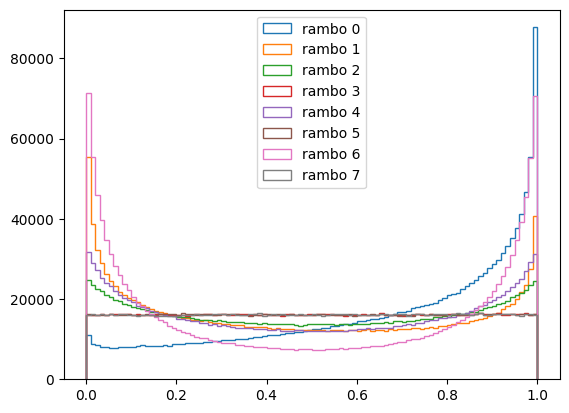

In [50]:
for i in range(8):
    plt.hist(ps[:,i], bins=100, range=(0,1), label=f"rambo {i}", histtype="step")
plt.legend()

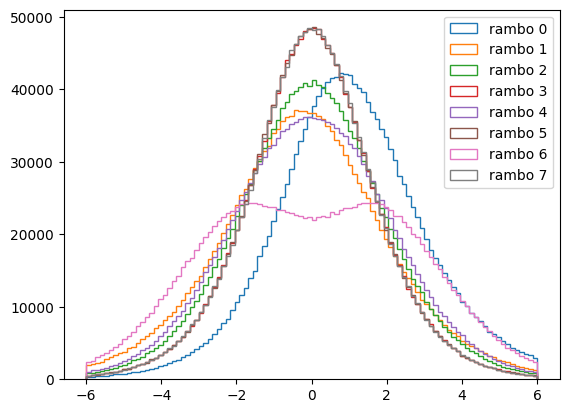

In [48]:
for i in range(8):
    plt.hist(ps_logit[:,i], bins=100, range=(-6,6), label=f"rambo {i}", histtype="step")
plt.legend()

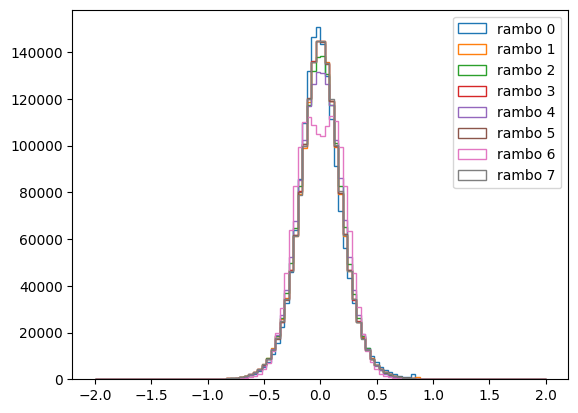

In [39]:
for i in range(8):
    plt.hist(ps_logit_scaled[:,i], bins=100, range=(-2,2), label=f"rambo {i}", histtype="step")
plt.legend()

In [ ]:


tensor([[ 1623.5075,   223.4688,   451.9513,  1538.1452],
        [ 1688.0451,   397.7945,   578.3958,  1525.4370],
        [ 2144.0061,    46.3070,  -503.6737,  2076.3368],
        [ 5209.7795,  -667.5703,  -526.6734, -5139.9190]], device='cuda:0',

In [ ]:
ensor([1.1069e+04, 0.0000e+00, 5.6843e-14, 2.9620e+03], device='cuda:0',


In [41]:
x1 = (boost.E + boost.pz)/13000
x2 = (boost.E - boost.pz)/13000

(array([2.91290e+04, 9.96060e+04, 1.27243e+05, 1.29853e+05, 1.22373e+05,
        1.13395e+05, 1.02573e+05, 9.12610e+04, 8.17130e+04, 7.30590e+04,
        6.58590e+04, 5.83620e+04, 5.21850e+04, 4.67960e+04, 4.21970e+04,
        3.73990e+04, 3.36140e+04, 3.03440e+04, 2.70960e+04, 2.42730e+04,
        2.18900e+04, 1.99090e+04, 1.76540e+04, 1.60210e+04, 1.45030e+04,
        1.29870e+04, 1.17560e+04, 1.05610e+04, 9.62300e+03, 8.65200e+03,
        7.93200e+03, 7.03300e+03, 6.43000e+03, 5.84100e+03, 5.31000e+03,
        4.77100e+03, 4.28200e+03, 3.79700e+03, 3.49600e+03, 3.24700e+03,
        2.98900e+03, 2.69800e+03, 2.37500e+03, 2.17000e+03, 1.86900e+03,
        1.69500e+03, 1.56900e+03, 1.40800e+03, 1.25100e+03, 1.18400e+03,
        1.05400e+03, 9.34000e+02, 8.27000e+02, 7.32000e+02, 6.80000e+02,
        6.11000e+02, 5.28000e+02, 4.68000e+02, 4.15000e+02, 3.69000e+02,
        3.39000e+02, 3.08000e+02, 2.63000e+02, 2.42000e+02, 2.19000e+02,
        1.74000e+02, 1.70000e+02, 1.33000e+02, 1.41

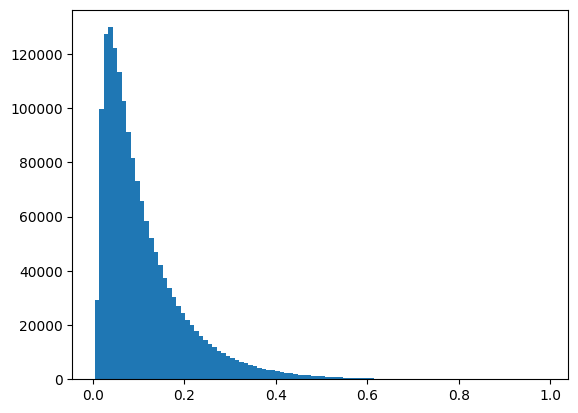

In [43]:
plt.hist(x1, bins=100)

In [47]:
ak.max(x2)


0.9515638398389535

In [54]:
torch.stack((torch.tensor([1,2,3,4,5]),torch.tensor([6,7,87,88,99])))


tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7, 87, 88, 99]])